<a href="https://colab.research.google.com/github/j-kohmaru-gunma/AraMaNet/blob/main/AramaLibrary.v2.00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.sparse as sp
import time

# 行列サイズ
N = 10000

# 疎度（0.9なら90%がゼロ）
sparsity = 0.99

# ==== NumPyによる密行列 ====
dense_matrix = np.random.rand(N, N)
dense_matrix[dense_matrix < sparsity] = 0  # 疎度を加える（0が多くなる）
dense_vector = np.random.rand(N)

start = time.time()
dense_result = dense_matrix @ dense_vector
end = time.time()
print(f"[NumPy] Dense matvec time: {end - start:.4f} 秒")

# ==== SciPy疎行列 ====
sparse_matrix = sp.csr_matrix(dense_matrix)  # 同じデータを疎行列に変換

start = time.time()
sparse_result = sparse_matrix @ dense_vector
end = time.time()
print(f"[SciPy] Sparse matvec time: {end - start:.4f} 秒")

# ==== 結果の確認 ====
difference = np.linalg.norm(dense_result - sparse_result)
print(f"結果の差（L2ノルム）: {difference:.4e}")

[NumPy] Dense matvec time: 0.1162 秒
[SciPy] Sparse matvec time: 0.0020 秒
結果の差（L2ノルム）: 1.4607e-12


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from matplotlib.animation import FuncAnimation
import scipy.sparse as sp
import time

class AramaNet:

    def __init__(self, input_dim=2, vmax=1024,lr=0.2):

        self.lr = lr # 学習率
        self.input_dim = input_dim #　入力次元
        self.vertex = VertexUnit(input_dim, vmax) #基点ユニット
        self.simplex = [] #　単体ユニット（初期は0層）
        self.max_nodes = 1024
        self._in = None #　入力
        self.train_log = []

    def forward(self, x, recon_error=0.1, update_flg=False):

        self._outlayer = 0
        self._in = x
        out = []

        # 入力がnp.int8かチェック
        if not (isinstance(x, np.ndarray) and x.dtype == np.uint8 and x.ndim == 1):
          raise ValueError("不正な値です。入力はnp.int8の一次元配列にしてください")

        # 頂点ユニット推論
        x = self.vertex.forward(x, update_flg)
        out.append(x)

        # 単体ユニット推論ループ
        for s in self.simplex:

            # 終了判定
            if False: break;

            # 単体ユニット推論
            x = s.forward(x, update_flg)
            out.append(x)

        # 出力
        return out

    def train(self,X,epoch=300):
        for _ in range(epoch):
            for i in range(len(X)):
                self.forward(X[i],update_flg=True)

            # 訓練ログ
            self.train_log.append([self.vertex.centers,self.vertex.scores])


"""
    def get_vertex(self,layer_num=0,node_idx=[0]):

        for i in range(layer_num+1):
            if len(self.simplex[layer_num-i].connect) > 0:
                node_idx = self.simplex[layer_num-i].connect[node_idx]
            else:
                node_idx = np.argsort(-self.simplex[layer_num-i].weights[node_idx])[:self.simplex[i].k]

        return np.unique(node_idx)

    def reconstruct_and_error(self, x, idx_list):

        # 各出力ノードに対応する基点群からバリセントリック近似
        points = self.vertex.centers[idx_list]  # 基点
        d = self.vertex.out[idx_list]
        weights = d / np.sum(d) + e.  # 正規化（バリセントリック風）
        recon = np.sum(points * weights[:, np.newaxis], axis=0)
        return recon, np.linalg.norm(self._out - recon, axis=0)
"""

class VertexUnit:

    def __init__(self, input_dim=2, max_nodes=1024, provisional_nodes_rate=0.1):

        self.input_dim = input_dim
        self.centers =  np.zeros((max_nodes, input_dim), dtype=np.uint8) #本ノード
        self.provisional = np.zeros(max_nodes, dtype=np.bool) #仮ノードフラグ
        self.provisional_nodes_rate = provisional_nodes_rate #仮ノード割合
        self.out = None #出力保存
        self.scores = np.zeros(len(self.centers), dtype=np.uint8)
        self.lr = 0.2

    def forward(self, x, update_flg=False):
        # 入力xに対し、基点ノードとの距離を計算し、出力を算出
        y = np.linalg.norm(x - self.centers, axis=1)

        #出力のスパース化
        y = self.sparse(y)

        #訓練
        if update_flg:
            self.update(x, y)
        return y

    def update(self, x, y):
        """
        出力結果に基づいて学習を実行。
        Winnerノードを決定し、移動度合いを調整して移動。
        その後スコアを更新し、仮ノードの管理も行う。
        """

        # 最も距離スコアの小さいノードをWinnerノードに決定
        sorted_y = np.argsort(y)
        winner_idx = sorted_y[0]
        winner_y = y[winner_idx]

        # ノードの移動
        self.centers[winner_idx] += np.sign(x - self.centers[winner_idx])

        # スコア更新
        self.scores[winner_idx] += 1

        # スコアが255を超えたら補正
        if self.scores[winner_idx] >= 255:
            self.scores = self.scores//2

        """
        # 移動したのが仮ノードの場合、昇格判定
        if not self.provisional[winner_idx]:
            if self.scores[winner_idx] > np.min(self.scores[self.provisional]):
                self.provisional[winner_idx] = True
        """

        # 外れ値判定
        if winner_y > np.linalg.norm(self.centers[winner_idx] - self.centers[sorted_y[1]]) * 2:
            self.add_provisional_node(x)


    def add_provisional_node(self,x):
        """
        仮ノードを設置する処理
        """
        #スコア0のノードがあれば設置
        idx = np.where(self.scores==0)
        if len(idx) > 0:
            self.centers[idx[0]] = x
            self.scores[idx[0]] = 1


    def redistribute_nodes(self, perturb_std=0.05):
        """
        スコアの低い本ノードをスコアの高いノード近傍に再配置してノードの密集を緩和する処理
        なお仮ノードは再配置の対象外
        """

        # 最もスコアの低いノード1個を選択して削除候補に
        prune_idx = np.argmin(self.scores)

        # 最もスコアの低いノード1個を選択して複製先に
        dup_idx = np.argmax(self.scores)

        # 複製
        perturb = np.random.randn(self.input_dim) * perturb_std
        self.centers[prune_idx] = self.centers[dup_idx] + perturb

        # スコアを分割
        self.scores[[prune_idx,dup_idx]] = self.scores[dup_idx] * 0.5

    # スパース化
    def sparse(self, x):
      return x

"""
class SimplexUnit:
    def __init__(self, input_dim=2, max_nodes=32, k=2, sparse_rate=0.6):
        self.max_nodes = max_nodes #最大ノード数
        self.k = k # 各ノードが接続を持つ基点の数
        self.connect = np.zeros((0,k),dtype=np.int32) # 各ノードが接続する基点の組み合わせ
        self.connect_weight = np.zeros(0) # 接続強度
        self.out = np.array([]) #単体層の出力保存用1
        self.out_idx = np.array([]) #単体層の出力保存用2
        self.weights = np.abs(np.random.rand(max_nodes, input_dim))


    def forward(self, x):

        #接続が確定済みかどうかで処理を分ける
        if len(self.connect) > 0: # 訓練済
            topk_indices = self.connect

        else: # 訓練中
            # 各ノードごとに、重みの大きい上位k個のインデックスを取得
            topk_indices = np.argpartition(-self.weights, kth=self.k-1, axis=0)[:, :self.k]

        # 入力xのうち、選ばれたインデックスに対応する値を取り出す（各ノードごとに）
        topk_values = np.take_along_axis(x[None, :], topk_indices, axis=1)

        # 有効な要素数を数え、平均値を求める（= 活性値）
        valid_counts = np.full((len(topk_indices)), self.k)
        sums = np.sum(topk_values, axis=1)
        self.out = sums / valid_counts  # 単純平均

        return self.out


    # 全テストデータ用いた簡易最適化
    def optimize(self, X, max_nodes=31):
        top_k = np.argsort(X)[:,-self.k:]
        top_k = np.sort(top_k,axis=1)

        unique_rows, counts = np.unique(top_k, axis=0, return_counts=True)
        idx = np.argsort(-counts)
        unique_rows = unique_rows[idx][0:max_nodes]
        counts = counts[idx][0:max_nodes]
        for row, count in zip(unique_rows, counts):
            self.connect = np.insert(self.connect, 0, row, axis=0)
            self.connect_weight = np.insert(self.connect_weight, 0, count, axis=0)

        # 結果表示
        return unique_rows, counts
"""

# データ準備
X, _ = make_swiss_roll(n_samples=1000, noise=0.2)
X = X[:, [0, 2]]  # 2次元に射影
X = (X / np.max(np.abs(X)))
X = (X + 1) / 2 * 255
X = X.astype(np.uint8)

# ネットワーク初期化
net = AramaNet(len(X[0]),24)

#訓練
net.train(X,epoch=50)

/tmp/ipython-input-53-4039966467.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('jet')


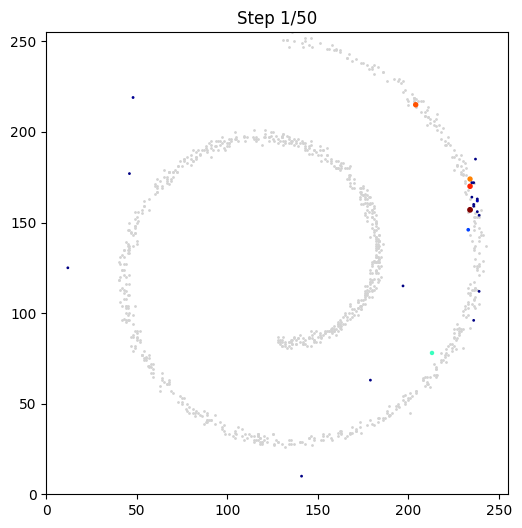

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.cm import get_cmap

# ▼ スコアの正規化関数（0〜255 → 0〜1）
def normalize_scores(scores):
    min_s, max_s = np.min(scores), np.max(scores)
    if max_s == min_s:
        return np.ones_like(scores)
    return (scores - min_s) / (max_s - min_s)

# ▼ 描画準備
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 255)
ax.set_ylim(0, 255)
ax.set_aspect('equal')
ax.set_title("Vertex Centers and Scores during Training")

# 背景の入力データ（灰色点）
ax.scatter(X[:,0], X[:,1], color='lightgray', s=1, label='Input Data')

# 頂点点群（初期化）
scatter = ax.scatter([], [], s=[], c=[], cmap='jet', vmin=0, vmax=255)

# カラーマップ
cmap = get_cmap('jet')

# ▼ フレームごとの更新関数
def update(frame):
    centers, scores = net.train_log[frame]
    centers = np.array(centers)
    scores = np.array(scores)

    # サイズと色をスコアに基づいて決定
    sizes = 1 + 9 * normalize_scores(scores)  # size range: 1～10
    colors = scores  # スコア値をそのまま色マップに渡す（0～255）

    scatter.set_offsets(centers)
    scatter.set_sizes(sizes)
    scatter.set_array(colors)
    ax.set_title(f"Step {frame+1}/{len(net.train_log)}")

    return scatter,

# ▼ アニメーション作成
ani = animation.FuncAnimation(fig, update, frames=len(net.train_log), interval=300, blit=False)

# ▼ Colab 上で表示
from IPython.display import HTML
HTML(ani.to_jshtml())


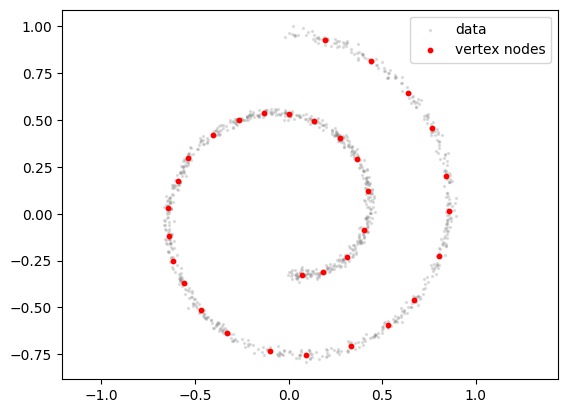

In [ ]:
#可視化
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

#頂点層
plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.2)
plt.scatter(net.vertex.centers[:, 0], net.vertex.centers[:, 1], c='red', label='vertex nodes', s=10)

plt.legend()
plt.axis("equal")
plt.show()

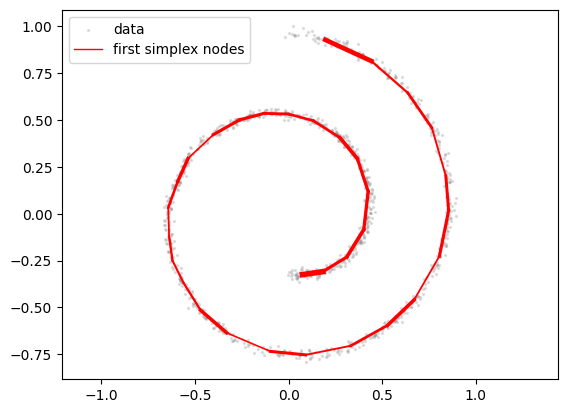

In [ ]:
#可視化
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

#第一単体層
line_idx = net.simplex[0].connect
w = net.simplex[0].connect_weight
w = w/np.max(w)
for i in range(len(line_idx)):
    p1 = net.vertex.centers[line_idx[i,0]]
    p2 = net.vertex.centers[line_idx[i,1]]
    plt.plot([p1[0],p2[0]], [p1[1],p2[1]], c='red', lw=w[i]*4)

plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.2)
plt.plot([p1[0],p2[0]], [p1[1],p2[1]], c='red', label='first simplex nodes', lw=1)

plt.legend()
plt.axis("equal")
plt.show()